# 多臂老虎机
## 简介
强化学习关注智能体和环境交互过程中的学习。在正式学习强化学习之前，我们通常需要先了解多臂老虎机问题，它可以认为是简化版的强化学习问题。与强化学习不同，多臂老虎机不存在状态信息，只有动作和奖励，可以算是最简单的“和环境交互中的学习”的一种形式。多臂老虎机中的探索与利用问题（Exploration and Exploitation）一直以来都是经典问题，理解它能够帮助我们之后学习强化学习的内容。
## 问题介绍

### 问题定义

在多臂老虎机（Multi-Armed Bandit，MAB）问题中，有一个拥有 $K$ 根拉杆的老虎机，每一个拉杆都对应一个关于奖励的概率分布$\mathcal{R}$。我们每次拉下其中一根拉杆，就可以获得一个从该拉杆对应的奖励概率分布中获得一个奖励$r$。我们的目标是: 在各个拉杆奖励的概率分布未知的情况下，从头开始尝试，并在操作 $T$ 次拉杆后，获得尽可能多的累积奖励。由于奖励的分布是未知的，我们就需要在“探索拉杆的获奖概率”和“根据经验选择获奖最多的拉杆”中进行权衡。于是，要采用怎样的操作策略，才能使获得的累积奖励最多，便是多臂老虎机问题。如果是你，会怎么做呢？
    
### 形式化描述
    
多臂老虎机问题可以表示为一个元组 $\left\langle \mathcal{A}, \mathcal{R} \right\rangle$，其中：
* $\mathcal{A}$ 为动作集合，其中一个动作表示拉动一个拉杆。若多臂老虎机一共有$K$个拉杆，那动作空间就是集合$\{1, \dots, K\}$，我们用$a \in \mathcal{A}$ 表示任意一个动作。
* $\mathcal{R}$ 为奖励函数分布，每一个拉杆$a$都对应一个奖励分布$\mathcal{R}( r | a) $，不同拉杆之间的奖励分布通常是不同的。

假设每个时间步只能拉动一个拉杆，多臂老虎机的目标为最大化一段时间步$T$内累积的奖励: $\max \sum_{t=1}^{T} r_t,\ r_t \sim \mathcal{R}\left( \cdot | a_t \right)$。其中$a_t$表示在第$t$时间步拉动的拉杆，$r_t$表示拉动拉杆$a_t$后获得的奖励。
		
### 累积懊悔 (Cumulative Regret)

对于每一个拉杆a，我们定义其**期望奖励**为$Q(a) = \mathbb{E}_{r\sim\mathcal{R}(\cdot|a)} \left[r\right]$。于是，至少存在一个拉杆，它的期望奖励不小于其他任意一个拉杆。我们将该最优期望奖励表示为 $Q^* = \max_{a \in \mathcal{A}} Q(a)$。为了更加直观、方便地观察一个拉杆离最优拉杆期望奖励的差距，我们引入**懊悔**概念。**懊悔**定义为当前拉杆$a$与最优拉杆的期望奖励差，即 $R(a) = Q^* - Q(a)$。**累积懊悔**即操作 $T$ 次拉杆后累积的懊悔总量，对于一次完整的T步决策$\{a_1,a_2,...,a_T\}$，累积懊悔为 $\sigma_R = \sum_{t=1}^T R(a_t)$。MAB问题的目标为最大化累积奖励，等价于最小化累积懊悔。

### 估计期望奖励

为了知道哪一个拉杆能获得更高的奖励，我们需要估计这个拉杆的期望奖励。只拉动一次获得的奖励存在随机性，所以需要拉动一个拉杆多次，然后计算得到的多次奖励的平均值。算法流程如下所示

- 对于$\forall a \in \mathcal{A}$,初始化期望奖励估值$\ \hat{Q}(a) = 0$和计数器 $N(a) = 0$
- 主循环 $t = 1:T$
	- 选取某个拉杆 $a_t$
	- 得到奖励 $r_t$
	-	更新计数器: $N(a_t) = N(a_t) + 1$
	- 更新估值: $\displaystyle \hat{Q}(a_t) = \hat{Q}(a_t) + \frac{1}{N(a_t)} \left[ r_t - \hat{Q}(a_t) \right]$
	
以上第4步我们如此更新估值，是因为这样我们可以进行增量式的平均数更新，公式如下。
$$
\begin{align}
 Q_k &=\frac{1}{k}\sum_{i=1}^{k} r_i \nonumber \\
 &= \frac{1}{k}(r_k + \sum_{i=1}^{k-1}r_i)  \nonumber \\
				&= \frac{1}{k}(r_k + (k-1)Q_{k-1}) \nonumber \\
				&= \frac{1}{k}(r_k + kQ_{k-1} - Q_{k-1}) \nonumber \\
				&= Q_{k-1} + \frac{1}{k}[r_k-Q_{k-1}]   \nonumber
\end{align}
$$

如果采用所有数求和再除以次数，存在一个缺点是每次更新的时间和空间复杂度均为$O(n)$。而采用增量式更新，时间和空间复杂度为 $O(1)$。

下面我们将用代码实现一个多臂老虎机，拉杆数为10。其中每个拉杆的奖励服从伯努利分布，即每次拉下拉杆有 $p$ 的概率获得奖励为1，剩下$1-p$ 的概率获得奖励为0。奖励为1代表获奖，奖励为0代表没有获奖。

In [1]:
# 导入需要使用的库，其中numpy是支持数组和矩阵运算的科学计算库，而matplotlib是绘图库
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class BernoulliBandit:
    """ 伯努利多臂老虎机，输入K为拉杆个数 """
    def __init__(self, K):
        self.probs = np.random.uniform(size=K) # 随机生成K个0-1之间的数，作为每个拉杆的获奖概率
        self.best_idx = np.argmax(self.probs) # 获奖概率最大的拉杆
        self.best_prob = self.probs[self.best_idx] # 最大的获奖概率
        self.K = K

    def step(self, k):
        # 当玩家选择了k号拉杆后，根据该老虎机k号拉杆获得奖励的概率返回 1（获奖）或 0（未获奖）
        if np.random.rand() < self.probs[k]:
            return 1
        else:
            return 0

np.random.seed(1) # 设定随机种子，使实验具有可重复性
K = 10
bandit_10_arm = BernoulliBandit(K)
print("随机生成了一个 %d臂伯努利老虎机" % K)
print("获得奖励概率最大的拉杆为%d号，其获奖概率为%.4f" % (bandit_10_arm.best_idx, bandit_10_arm.best_prob))

随机生成了一个 10臂伯努利老虎机
获得奖励概率最大的拉杆为1号，其获奖概率为0.7203


接下来我们以一个Solver基础类来实现上述的多臂老虎机的求解方案。根据前文的算法框架，我们需要实现下列函数：根据策略选择动作，根据动作获取奖励，更新奖励估值，更新累积懊悔和计数。在下面的MAB算法基本框架中，我们将 *根据策略选择动作*、*根据动作获取奖励* 和 *更新期望奖励估值* 放在 `run_one_step` 函数中，由每个继承Solver类的策略具体实现。而 *更新累积懊悔和计数* 则直接放在主循环 `run` 中。

In [3]:
class Solver:
    """ 多臂老虎机算法基本框架 """
    def __init__(self, bandit):
        self.bandit = bandit                   
        self.counts = np.zeros(self.bandit.K) # 每个拉杆的尝试次数
        self.regret = 0. # 当前步的累积懊悔
        self.actions = [] # 维护一个列表，记录每一步的动作
        self.regrets = [] # 维护一个列表，记录每一步的累积懊悔

    def update_regret(self, k):
        # 计算累积懊悔并保存，k为本次行动选择的拉杆的编号
        self.regret += self.bandit.best_prob - self.bandit.probs[k]
        self.regrets.append(self.regret)

    def run_one_step(self):
        # 返回当前行动选择哪一个拉杆，由每个具体的策略实现
        raise NotImplementedError

    def run(self, num_steps):
        # 运行一定次数，num_steps为总运行次数
        for _ in range(num_steps):
            k = self.run_one_step()
            self.counts[k] += 1
            self.actions.append(k)
            self.update_regret(k)

## 探索与利用问题
在以上算法流程中，还没有一个策略告诉我们应该采取哪个动作，即拉动哪个拉杆，所以接下来我们将来学习如何设计一个策略。例如一个最简单的策略就是一直采取第一个动作，但这就非常取决于运气。如果运气绝佳，可能刚好是能获得最大期望奖励的拉杆，即最优拉杆；但如果运气很糟糕，就有可能是最小的期望奖励。于是在多臂老虎机任务中，一个经典的问题就是探索与利用的平衡问题。策略的设计就需要考虑这个问题。其中**探索(Exploration)** 是指尝试更多可能的拉杆，这个拉杆不一定会获取最优奖励，但能够清楚所有拉杆的获奖情况，也即对于一个10臂老虎机，我们要去把所有的拉杆都试一下才知道哪个拉杆可能获得最大的奖励。而**利用 (Exploitation)** 是指拉动已知平均奖励中最优的那个拉杆。由于已知的信息仅仅来自于有限次的交互观测，所以当前最优的拉杆不一定是真正全局最优。例如，对于一个10臂老虎机，我们只试过其中3个拉杆，接下来就一直拉动这3个拉杆中平均奖励最大的那个拉杆，但很有可能期望奖励最大的拉杆在剩下7个当中；即使我们对10个拉杆各自都尝试过了20次，发现5号拉杆的经验平均奖励是最高的，但仍然存在着微小的概率使得另一个6号拉杆的真实期望奖励是比5号拉杆更高的。

于是在多臂老虎机问题中，我们需要平衡探索和利用的次数，使得能最大化累积奖励。一个比较大致的思路是在一开始的时候做比较多的探索，在对每个拉杆都有比较准确的估计后，再进行利用。目前存在一些比较经典的算法来解决这个问题，它们是$\epsilon$-贪心算法、UCB算法、汤普森采样算法，我们接下来将分别着重介绍。

## ϵ-贪心算法

如果是完全的贪心算法，即在每一时刻采取期望奖励估值最大的动作（拉杆），这就是纯粹的利用，而没有探索。所以需要对完全贪心算法进行一些修改。其中比较经典的一种方法为$\epsilon$-贪心算法 ($\epsilon$-Greedy)，在完全贪心算法的基础上添加了噪声，每次以概率 $1 - \epsilon$ 选择以往经验中期望奖励估值最高的那个拉杆，以概率 $\epsilon$ **随机**选择一个拉杆。
		
随着时间的不断推进，我们对各个动作的奖励估计得越来越准，此时我们就没太大必要继续花大力气进行探索。所以在$\epsilon$-贪心算法的具体实现中，我们可以令$\epsilon$ 随时间衰减，也即探索的概率将会不断降低。但是请注意，$\epsilon$不会在有限的步数内衰减至0，因为基于有限步数观测的完全贪心算法仍然是一个局部信息的贪心算法，永远距离最优解有一个固定的差距。


我们接下来用代码实现一个$\epsilon$-贪心算法，并用它去解决前文生成的10臂老虎机。我们设置$\epsilon = 0.01$，以及$T=5000$。

In [4]:
class EpsilonGreedy(Solver):
    """ Epsilon贪心算法，继承Solver类 """
    def __init__(self, bandit, epsilon=0.01, init_prob=1.0):
        super(EpsilonGreedy, self).__init__(bandit)
        self.epsilon = epsilon
        self.estimates = np.array([init_prob] * self.bandit.K) #初始化对所有拉杆的奖励估值

    def run_one_step(self):
        if np.random.random() < self.epsilon:
            k = np.random.randint(0, self.bandit.K)  # 随机选择一个拉杆
        else:
            k = np.argmax(self.estimates)  # 选择奖励估值最大的拉杆
        r = self.bandit.step(k)  # 得到本次动作的奖励
        self.estimates[k] += 1. / (self.counts[k] + 1) * (r - self.estimates[k])
        return k

为了更加直观地展示，我们把每一时间步的累积函数画出来。于是我们定义了以下画图函数，方便之后调用。

In [5]:
def plot_results(solvers, solver_names):
    """生成累积懊悔随时间变化的图像。输入solvers是一个列表，列表中每个元素是一种特定的策略。而solver_names也是一个列表，包含每个策略的名称"""
    for idx, solver in enumerate(solvers):
        time_list = range(len(solver.regrets))
        plt.plot(time_list, solver.regrets, label=solver_names[idx])
    plt.xlabel('Time steps')
    plt.ylabel('Cumulative regrets')
    plt.title('%d-armed bandit' % solvers[0].bandit.K)
    plt.legend()
    plt.show()

epsilon贪心算法的累积懊悔为： 25.526630933945313


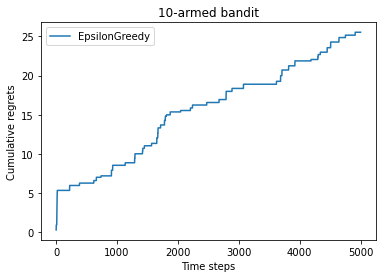

In [6]:
np.random.seed(1)
epsilon_greedy_solver = EpsilonGreedy(bandit_10_arm, epsilon=0.01)
epsilon_greedy_solver.run(5000)
print('epsilon贪心算法的累积懊悔为：', epsilon_greedy_solver.regret)
plot_results([epsilon_greedy_solver], ["EpsilonGreedy"])

通过上面实验我们发现，在经历了开始的一小段时间后，$\epsilon$-贪心算法的累积懊悔几乎是线性增长的。这是$\epsilon=0.01$时的结果，因为一旦做出了随机拉杆的探索，那么带来的懊悔值是固定的。那其他不同的 $\epsilon$ 取值又会带来怎样的变化呢？我们继续使用该10臂老虎机，我们尝试不同的参数: $\{10^{-4}, 0.01, 0.1, 0.25, 0.5\}$，查看相应实验结果。

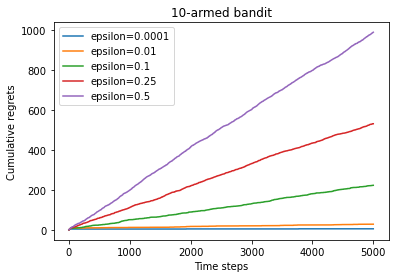

In [8]:
np.random.seed(0)
epsilons = [1e-4, 0.01, 0.1, 0.25, 0.5]
epsilon_greedy_solver_list = [EpsilonGreedy(bandit_10_arm, epsilon=e) for e in epsilons]
epsilon_greedy_solver_names = ["epsilon={}".format(e) for e in epsilons]
for solver in epsilon_greedy_solver_list:
    solver.run(5000)
plot_results(epsilon_greedy_solver_list, epsilon_greedy_solver_names)

通过实验结果，我们发现基本上无论$\epsilon$取值多少，累积懊悔都是线性增长的。在这个例子中，随着$\epsilon$的增大，累积懊悔增长的速率也会增大。

接下来我们尝试$\epsilon$值随时间衰减的$\epsilon$-贪心策略，采取的具体衰减形式为线性衰减，具体公式为 $\epsilon_t = \frac{1}{t}$。

In [9]:
class DecayingEpsilonGreedy(Solver):
    """ epsilon取值随时间衰减的Epsilon贪心算法，继承Solver类 """
    def __init__(self, bandit, init_prob=1.0):
        super(DecayingEpsilonGreedy, self).__init__(bandit)
        self.estimates = np.array([init_prob] * self.bandit.K)
        self.total_count = 0

    def run_one_step(self):
        self.total_count += 1
        if np.random.random() < 1 / self.total_count: # epsilon随时间衰减
            k = np.random.randint(0, self.bandit.K) 
        else:
            k = np.argmax(self.estimates)  
        
        r = self.bandit.step(k) 
        self.estimates[k] += 1. / (self.counts[k] + 1) * (r - self.estimates[k])

        return k

epsilon衰减的贪心算法的累积懊悔为： 10.114334931260183


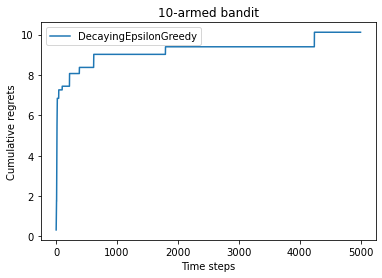

In [10]:
np.random.seed(1)
decaying_epsilon_greedy_solver = DecayingEpsilonGreedy(bandit_10_arm)
decaying_epsilon_greedy_solver.run(5000)
print('epsilon衰减的贪心算法的累积懊悔为：', decaying_epsilon_greedy_solver.regret)
plot_results([decaying_epsilon_greedy_solver], ["DecayingEpsilonGreedy"])

从上图我们看到，随着时间做指数衰减的$\epsilon$-贪心策略能够使得累计懊悔与时间的关系变成次线性 (Sublinear) 的，这明显优于固定$\epsilon$值的$\epsilon$-贪心策略。

## 上置信界算法 (Upper Confidence Bound, UCB)

设想这样一种情况：对于一台2臂老虎机，其中第一个拉杆只尝试过一次，得到奖励为0；第二个拉杆尝试过很多次，对它的奖励分布有了大致的把握。这时你会怎么做？或许你会进一步尝试第一个拉杆，来更加确定其奖励分布。这种思路主要是基于不确定性，因为此时第一个拉杆只试了一次，它的不确定性很高。如果一个拉杆它的不确定性越大，那么其就越具有探索的价值，因为探索之后可能发现它的奖励很大。我们在此引入不确定性度量$U(a)$，其会随着一个动作尝试的次数增加而减小。因此可以使用一种基于不确定性的策略为，综合考虑现有的期望奖励估值和不确定性，其核心问题是如何估计不确定性。

上置信界算法UCB (Upper Confidence Bound) 是一种经典的基于不确定性的策略算法。它的思想用到了一个非常著名的数学原理：霍夫丁不等式 *(Hoeffding's Inequality)*。在霍夫丁不等式中，令 $X_1,...,X_n$ 为 $n$ 个独立同分布的随机变量，取值范围为 $[0,1]$，其经验期望为 $\bar{x}_n = \frac{1}{n}\sum_{j=1}^{n}X_j$，则有
$$
\begin{align*}
\mathbb{P}\left\{ \mathbb{E}\left[X\right] \geq \bar{x}_t + u \right\} \leq e^{-2nu^2} 
\end{align*}
$$

现在我们将霍夫丁不等式运用于多臂老虎机问题中。 将$\hat{Q}_t(a)$ 代入 $\bar{x}_t$，并认为不等式中的参数 $u = \hat{U}_t(a)$ 代表不确定性度量。给定一个概率 $p= e^{-2N_t(a)U_t(a)^2}$，根据不等式，$Q_t(a) < \hat{Q}_t(a) + \hat{U}_t(a)$ 至少以概率 $1-p$ 成立。当$p$很小时，$Q_t(a) < \hat{Q}_t(a) + \hat{U}_t(a)$就以很大概率成立，此时$\hat{Q}_t(a) + \hat{U}_t(a)$便是期望奖励的上界。于是，上置信界算法便选取期望奖励上界最大的动作，即$a = \underset{a\in\mathcal{A}}{\text{argmax}} \left[\hat{Q}(a) + \hat{U}(a)\right]$。那其中$\hat{U}_t(a)$具体是什么呢？根据$式子e^{-2N_t(a)U_t(a)^2}$，解之即得 $\hat{U}_t(a) = \sqrt{\frac{-\log p}{2N_t(a)}}$。所以设定一个概率$p$后，就可以计算相应的不确定性度量$\hat{U}_t(a)$了。更直观地说，UCB方法在每次选择拉杆前，先估计每根拉杆的期望奖励的上界，使得每根拉杆的期望奖励只有一个较小的概率 $p$ 超过这个上界。接着选出期望奖励上界最大的拉杆，从而选择最有可能是期望奖励最大的拉杆。



我们下面将用代码实现UCB算法，并且仍然使用上文定义的10臂老虎机来观察实验结果。在具体实现过程中，我们设置$p=\frac{1}{t}$，并且在分母中每个拉杆的次数加上常数1，以免出现除以0的情形，即此时$\hat{U}_t(a) = \sqrt{\frac{\log t}{2(N_t(a)+1)}}$。并且我们设定一个系数$c$来控制不确定性的比重，此时$a = \underset{a\in\mathcal{A}}{\text{argmax}} \left[\hat{Q}(a) + c \cdot \hat{U}(a)\right]$

In [11]:
class UCB(Solver):
    """ UCB算法，继承Solver类 """
    def __init__(self, bandit, coef, init_prob=1.0):
        super(UCB, self).__init__(bandit)
        self.total_count = 0
        self.estimates = np.array([init_prob] * self.bandit.K)
        self.coef = coef

    def run_one_step(self):
        self.total_count += 1
        ucb = self.estimates + self.coef * np.sqrt(np.log(self.total_count) / (2 * (self.counts + 1))) # 计算上置信界
        k = np.argmax(ucb) # 选出上置信界最大的拉杆
        r = self.bandit.step(k)
        self.estimates[k] += 1. / (self.counts[k] + 1) * (r - self.estimates[k])
        return k

上置信界算法的累积懊悔为： 4.360254345326592


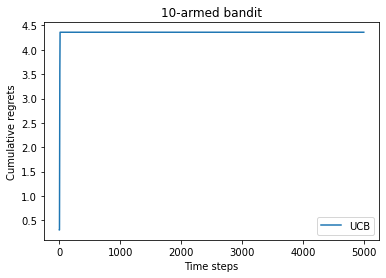

In [12]:
np.random.seed(1)
coef = 0.1 # 控制不确定性比重的系数
UCB_solver = UCB(bandit_10_arm, coef)
UCB_solver.run(5000)
print('上置信界算法的累积懊悔为：', UCB_solver.regret)
plot_results([UCB_solver], ["UCB"])

## 汤普森采样算法 (Thompson Sampling) 

MAB中还有一种经典算法为汤普森采样。我们先假设每个拉杆的奖励服从一个特定的分布，然后根据每个拉杆的期望奖励来进行选择。但是由于计算每个拉杆的期望奖励计算代价比较高，汤普森采样算法使用采样的方式，即根据当前每个动作 $a$ 的奖励分布进行一轮采样，得到一组各个拉杆的奖励样本，再选择样本中奖励最大的动作。我们可以看出，汤普森采样是一种计算每个拉杆产生最高奖励概率的蒙特卡罗采样方法。

了解了汤普森采样的基础思路后，需要解决另一个问题：当前每个动作 $a$ 的奖励分布怎样得到并且在过程中进行更新？在实际情况中，我们通常对当前每个动作的奖励分布用Beta分布进行建模。具体来说，若某拉杆选择了$k$次，其中$m_1$次奖励为1，$m_2$次奖励为0，则该拉杆的奖励服从参数为 $(m_1+1, m_2+1)$ 的Beta分布。下图是汤普森采样的一个示例。

<img src="https://staticcdn.boyuai.com/user-assets/358/5vUaGksi15BtPE8DyAJozj/qg2ueouwk0.png!png" width = "600" height = "600" align=center />
 
<center>汤普森采样示例 </center>

我们下面将用代码实现汤普森采样算法，并且仍然使用上文定义的10臂老虎机来观察实验结果。


In [13]:
class ThompsonSampling(Solver):
    """ 汤普森采样算法，继承Solver类 """
    def __init__(self, bandit):
        super(ThompsonSampling, self).__init__(bandit)
        self._a = np.ones(self.bandit.K)  # 列表，表示每个拉杆奖励为1的次数
        self._b = np.ones(self.bandit.K)  # 列表，表示每个拉杆奖励为0的次数

    def run_one_step(self):
        samples = np.random.beta(self._a, self._b) # 按照Beta分布采样一组奖励
        k = np.argmax(samples) # 选出采样数值最大的拉杆
        r = self.bandit.step(k)
        
        self._a[k] += r # 更新Beta分布的第一个参数
        self._b[k] += (1 - r) # 更新Beta分布的第二个参数
        return k

汤普森采样算法的累积懊悔为： 57.19161964443925


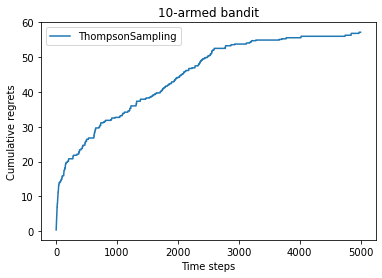

In [14]:
np.random.seed(1)
thompson_sampling_solver = ThompsonSampling(bandit_10_arm)
thompson_sampling_solver.run(5000)
print('汤普森采样算法的累积懊悔为：', thompson_sampling_solver.regret)
plot_results([thompson_sampling_solver], ["ThompsonSampling"])

通过实验我们得到以下结论：$\epsilon$-贪心策略的累积懊悔是随时间线性增长的，而另外三种算法（$\epsilon$衰减贪心算法、上置信界算法、汤普森采样算法）的累积懊悔都是次线性增长的（具体为对数形式增长）。

## 总结

探索与利用是与环境做交互性学习的重要问题，是强化学习 *试错法 (trial-and-error)* 中的必备技术，而 *多臂老虎机* 是研究探索与利用技术理论的最佳环境。了解多臂老虎机的探索与利用问题，对接下来我们学习强化学习的策环境探索有很重要的帮助。多臂老虎机各种算法存在理论上的累积懊悔分析，有兴趣的同学可以自行查阅相关资料。$\epsilon$-贪心、UCB和汤普森采样方法在多臂老虎机任务中十分常用，其中UCB和汤普森采样方法均能保证对数的渐进最优累积懊悔。

多臂老虎机和强化学习的一大区别在于与环境的交互并不会改变环境，即多臂老虎机的每次交互的结果和以往的行动无关，所以可看作是无状态的强化学习 (Stateless Reinforcement Learning)。接下来的章节，我们则开始在有状态的环境下，即马尔可夫决策过程，讨论强化学习算法。
